# 사전 학습된 ConvNet을 이용한 전이 학습

- [티스토리 참고링크](https://littlefoxdiary.tistory.com/86)
- [텐서플로우 전이학습 및 미세조정](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
from glob import glob


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
# import pickle
# # Load pickle
# with open("data.pickle","rb") as fr:
#     data = pickle.load(fr)
# print(data)
# history, history_fine = data[0],data[1]

## 데이터 전처리

### 데이터 구성하는 과정
- 이십만개의 데이터는 너무 많아서 10%인 이만개만 사용
  - 어떻게 나눌까? 데이터프레임을 이만개까지만 뽑고, csv의 파일명 컬럼으로 이미지 추출
- 트레인, 벨리데이션, 테스트 셋으로 나눠서 csv파일로 저장
  - 16000, 4000, 4000

In [3]:
# 데이터셋 수
datasetNumber = 20000

이미지 사이즈: (218, 178, 3)


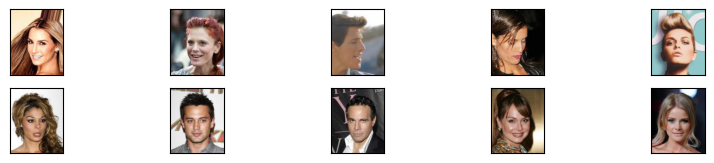

In [4]:
# 폴더 위치
PATH = 'C:/data/celeba/miniproject'

# csv 
df = pd.read_csv(PATH+'/list_attr_celeba.csv')
df = df[:datasetNumber]

# 이미지 주소
imgFolder = glob('C:/data/celeba/img_align_celeba/img_align_celeba/')
img_addr = imgFolder+df['fileName']

# 이미지 10장만 불러와서 확인
imgArr = []
for image in img_addr[:10]:
    imageRead = cv2.imread(image, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(imageRead) # cv2라서 plt로 확인해야 하니까 b,g,r로 분리
    imageRead = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
    imgArr.append(imageRead)

plt.figure(figsize=(10,10))
for i in range(len(imgArr)):
    plt.subplot(10,5,i+1)
    plt.xticks([]) 
    plt.yticks([]) 
    plt.imshow(imgArr[i])
    
print('이미지 사이즈:',np.shape(imgArr[0]))

In [5]:
df

,fileName,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,019996.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,1,-1,1
19996,019997.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
19997,019998.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
19998,019999.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1


In [6]:
df2 = df.copy()
df2 = df2.drop(columns=['fileName'])
df2[df2 == -1 ] = 0
df.iloc[:,1:] = df2
df

,fileName,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,019996.jpg,0,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1
19996,019997.jpg,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
19997,019998.jpg,0,1,1,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
19998,019999.jpg,0,1,1,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1


In [7]:
df.columns

Index(['fileName', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [8]:
df2 = df.copy()
df3 = pd.DataFrame()
df3['fileName'] = df2['fileName']
df3['Male'] = df2['Male']
# df3['Wearing_Earrings'] = df2['Wearing_Earrings']
df = df3
df


,fileName,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0
...,...,...
19995,019996.jpg,0
19996,019997.jpg,0
19997,019998.jpg,0
19998,019999.jpg,0


In [9]:
# 데이터셋 나누기
from sklearn.model_selection import train_test_split

# 트레인 12000, 밸리데이션 4000, 테스트 4000
train, test = train_test_split(df, random_state=777, test_size=0.2)
train, validation = train_test_split(train, random_state=777, test_size=0.25)

# 인덱스 초기화
train.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# 데이터셋 폴더 설정
trainPATH = os.path.join(PATH, 'train')
validationPATH = os.path.join(PATH, 'validation')
testPATH = os.path.join(PATH, 'test')

# 데이터셋 저장
train.to_csv(trainPATH+'/train.csv', header=False)
test.to_csv(testPATH+'/test.csv', header=False)
validation.to_csv(validationPATH+'/validation.csv', header=False)

np.shape(train), np.shape(validation), np.shape(test)

((12000, 2), (4000, 2), (4000, 2))

In [10]:
import shutil

# 데이터셋 폴더에 원본 이미지 복사
train_img = imgFolder+train['fileName']
train_img_dir = os.path.join(trainPATH,'image')

if not os.path.exists(train_img_dir):
    os.mkdir(train_img_dir)
    
for img in train_img:
    newDir = os.path.join(train_img_dir,os.path.basename(img))
    if not os.path.exists(newDir):
        shutil.copy(img, train_img_dir)

validation_img = imgFolder+validation['fileName']
val_img_dir = os.path.join(validationPATH,'image')

if not os.path.exists(val_img_dir):
    os.mkdir(val_img_dir)
    
for img in validation_img:
    newDir = os.path.join(val_img_dir,os.path.basename(img))
    if not os.path.exists(newDir):
        shutil.copy(img, val_img_dir)

test_img = imgFolder+test['fileName']
test_img_dir = os.path.join(testPATH,'image')

if not os.path.exists(test_img_dir):
    os.mkdir(test_img_dir)

for img in test_img:
    newDir = os.path.join(test_img_dir,os.path.basename(img))
    if not os.path.exists(newDir):
        shutil.copy(img, test_img_dir)

# 이미지 갯수
len(os.listdir(train_img_dir)), len(os.listdir(val_img_dir)), len(os.listdir(test_img_dir))

(12000, 4000, 4000)

In [11]:
train['fileName'] = train_img
validation['fileName'] = validation_img
test['fileName'] = test_img

In [12]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [13]:
# 이미지 제너레이터를 정의합니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [14]:
class_col = train.columns[1:]

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_img_dir,
    x_col = 'fileName',
    y_col = class_col,
    target_size = IMG_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation,
    directory=val_img_dir,
    x_col = 'fileName',
    y_col = class_col,
    target_size = IMG_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_img_dir,
    x_col = 'fileName',
    y_col = class_col,
    target_size = IMG_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 12000 validated image filenames.
Found 4000 validated image filenames.
Found 4000 validated image filenames.


Index(['Male'], dtype='object')


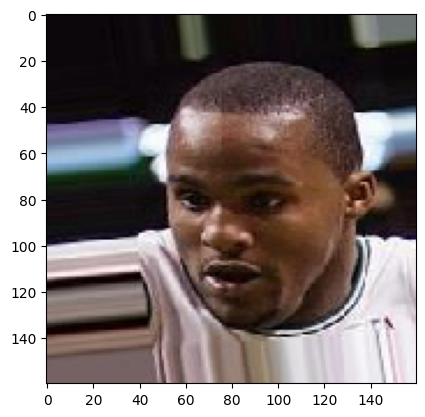

In [15]:
len(train_generator) # 375묶음

# 라벨링이 잘됐는지 확인
plt.imshow(train_generator[0][0][1]/255) 
for x in np.where(train_generator[0][1][1]==1):
    print(class_col[x])

<!-- - 문제1. image_dataset_from_directory는 정말 디렉토리 위치만 받음, csv의 주소를 할당하면 에러
  - 폴더를 만들어줘서 csv 이동 시킴
- 문제2. train_dataset는 train이라는 디렉토리에 이미지와 csv가 둘 다 있어야 함
  - train, val, test에 있는 파일명에 맞는 이미지를 기존 이미지 폴더에서 새로운 이미지 폴더로 이동시켜줘야 함
- 문제3. image_dataset_from_directory는 이미지 이름에 라벨링이 다 되어있어야함으로 멀티 레이블링은 어려움
- ```
    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
  ``` -->

### 데이터 증강 사용

In [16]:
# 데이터 증강을 이용해서 데이터셋의 규모를 키우고, 오버피팅 방지
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), # 수평으로 랜덤하게 뒤집기
  tf.keras.layers.RandomRotation(0.2), # 랜덤하게 회전시킨다
])

In [17]:
train_generator[0][0]

array([[[[183.,  26.,  11.],
         [183.,  26.,  11.],
         [183.,  26.,  11.],
         ...,
         [227.,  67.,  53.],
         [223.,  63.,  49.],
         [223.,  63.,  49.]],

        [[183.,  26.,  11.],
         [184.,  27.,  12.],
         [184.,  27.,  12.],
         ...,
         [225.,  65.,  51.],
         [223.,  63.,  49.],
         [223.,  63.,  49.]],

        [[184.,  27.,  12.],
         [184.,  27.,  12.],
         [184.,  27.,  12.],
         ...,
         [224.,  64.,  50.],
         [224.,  64.,  50.],
         [224.,  64.,  50.]],

        ...,

        [[141., 117.,  79.],
         [143., 119.,  81.],
         [143., 119.,  81.],
         ...,
         [233., 181., 159.],
         [242., 168., 143.],
         [171.,  87.,  59.]],

        [[141., 117.,  79.],
         [143., 119.,  81.],
         [142., 118.,  80.],
         ...,
         [239., 193., 169.],
         [255., 192., 165.],
         [181., 104.,  74.]],

        [[141., 117.,  79.],
       

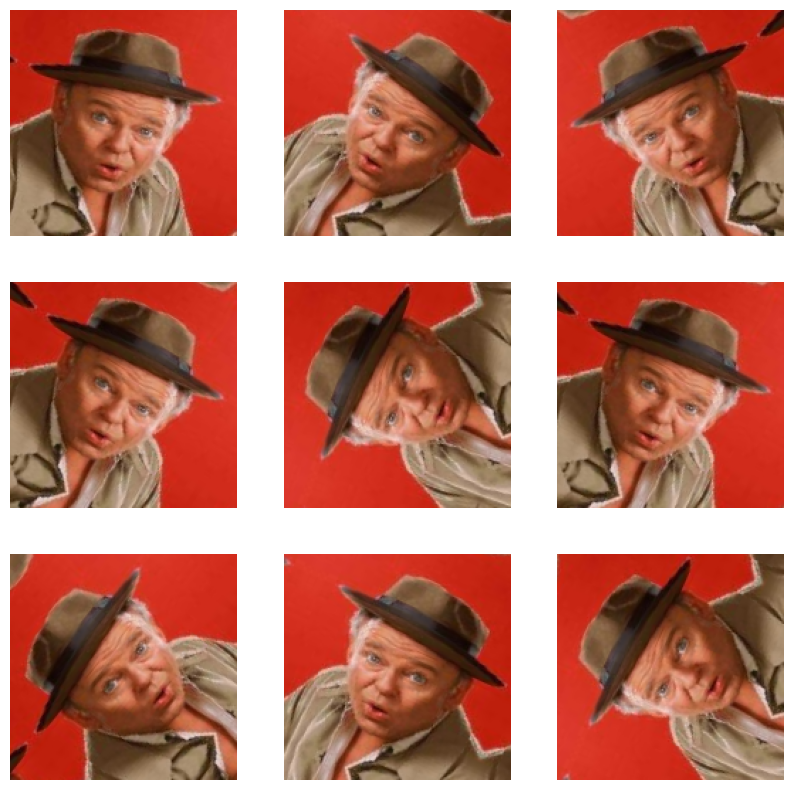

In [18]:
plt.figure(figsize=(10, 10))
first_image = train_generator[0][0][0] # 첫 사진
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) # 증강 적용
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [19]:
# 기본 모델 MobileNetV2은 -1~1사이의 픽셀 값만 인풋으로 받는다.
# 현재 이미지의 값은 0~255니까 preprocess_input으로 -1~1로 조정
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

[모바일넷v2 참고링크](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)

In [20]:
# MobileNet V2로 기본 모델 생성. 
# include_top = False로 디폴트 인풋 레이어를 사용하지 않음.
# imagenet으로 훈련된 가중치를 이용.

IMG_SHAPE = IMG_SIZE + (3,) # 160,160,3
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [21]:
# 160,160,3을 인풋으로 받고 5,5,1280으로 아웃풋
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


[전이학습 가이드 링크](https://www.tensorflow.org/guide/keras/transfer_learning?hl=ko)

In [22]:
# 훈련중에 주어진 레이어의 가중치가 업데이트 되는 것을 방지하기
# layer.trainable = False를 설정하면 BatchNormalization 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.
base_model.trainable = False

In [23]:
# 베이스 모델 확인하
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [24]:
# GlobalAveragePooling2D로 베이스 모델의 아웃풋을 피처벡터로 만드는 레이어 적용

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(len(class_col))
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(32, 5, 5, 1)


In [26]:
# 데이터 증강, 모바일넷v2, 분류레이어 적용

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # 시그모이드가 포함되어 있으면 False
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [30]:
# # 에포크 10으로 평가해보기
initial_epochs = 1

loss0, accuracy0 = model.evaluate(val_generator)

125/125 [==============================] - 18s 136ms/step - loss: 0.6333 - accuracy: 0.5870


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.59


In [32]:
# 에포크 10으로 훈련
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator)

375/375 [==============================] - 78s 204ms/step - loss: 0.4794 - accuracy: 0.7473 - val_loss: 0.3295 - val_accuracy: 0.8615


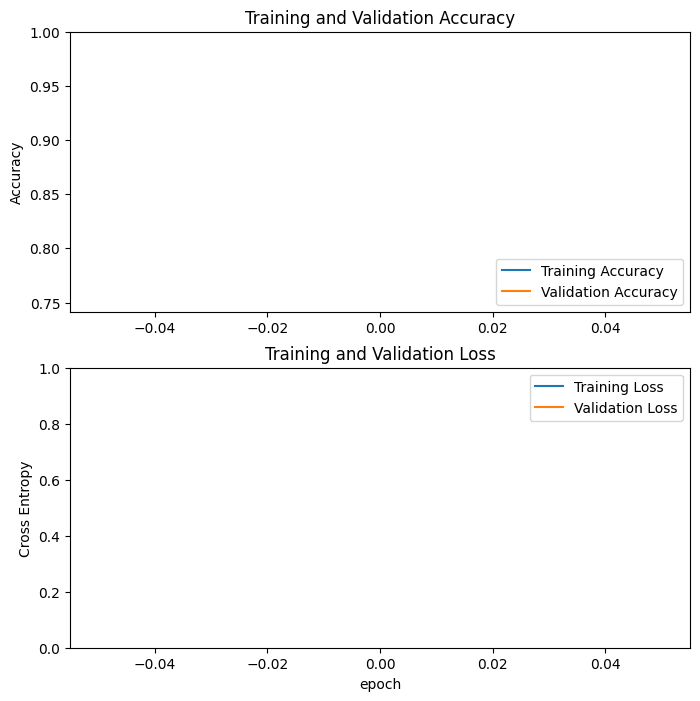

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# 사전 훈련된 네트워크의 가중치는 업데이트가 되지 않았다. 
# 이제 업데이트하면서 훈련할거다
# 베이스 모델 훈련 고정 해제
base_model.trainable = True

In [35]:
# 베이스 모델의 레이어 수
print("Number of layers in the base model: ", len(base_model.layers))

# 100번째부터 미세조정, 왜 그런지 기준은 모름
fine_tune_at = 100

# 100번째 이전은 다시 훈련 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [36]:
# 낮은 학습률을 사용, 빠르게 과대적합 될 수도 있어서임
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                     

In [38]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs # 에포크 합쳐서 훈련

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator)

Epoch 1/2
375/375 [==============================] - 119s 310ms/step - loss: 0.2784 - accuracy: 0.8752 - val_loss: 0.2247 - val_accuracy: 0.9137
Epoch 2/2
375/375 [==============================] - 115s 305ms/step - loss: 0.2162 - accuracy: 0.9057 - val_loss: 0.1841 - val_accuracy: 0.9265


In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

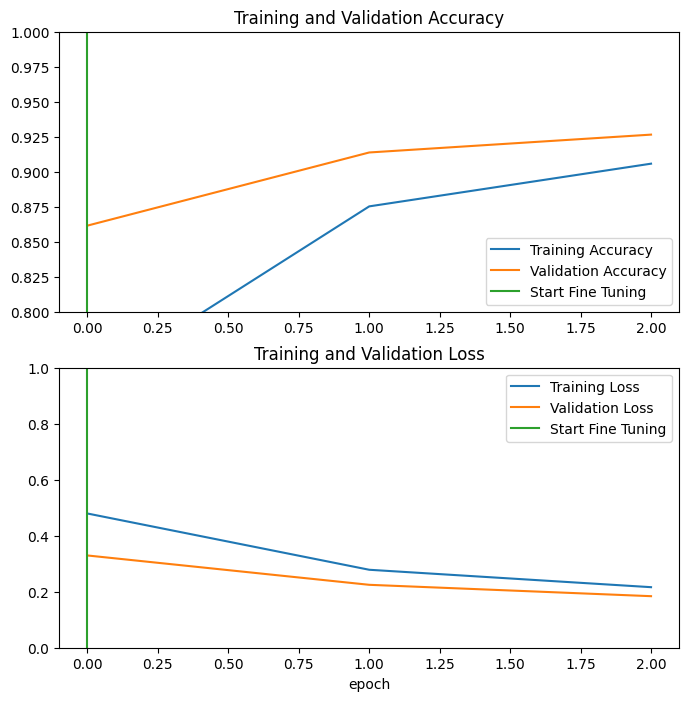

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 세이브


In [41]:
import time
t = time.time()

export_path = "./saved_models/{}.h5".format(int(t))
model.save(export_path)

export_path

c:\Users\user\miniconda3\envs\gpu\lib\site-packages\keras\src\engine\training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'./saved_models/1688695489.h5'

In [42]:
### 피클
import pickle
my_list = [history_fine, history]
 
## Save pickle
with open("data.pickle","wb") as fw:
    pickle.dump(my_list, fw)


### 평가 및 예측

In [43]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

125/125 [==============================] - 20s 161ms/step - loss: 0.1576 - accuracy: 0.9348
Test accuracy : 0.9347500205039978


In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_arr = []
label_arr = []

# Extract images and labels from the test_dataset
for i in range(len(test_generator)):   
    predictions = model.predict_on_batch(test_generator[i][0])
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    pred_arr.append(predictions)
    
    test_label = test_generator[i][1]
    label_arr.append(test_label)

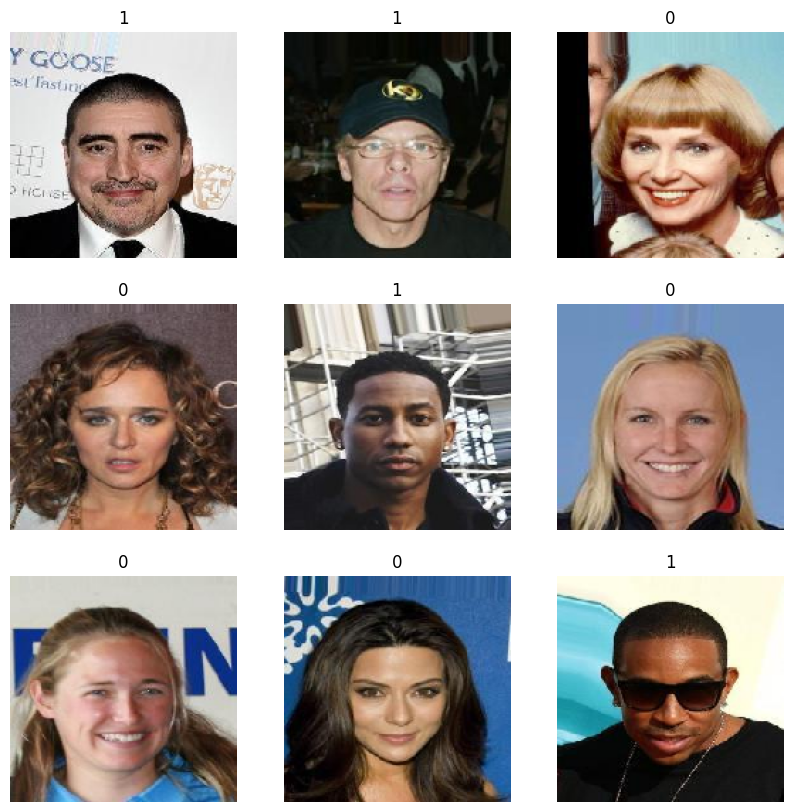

In [113]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(test_generator[0][0][i].astype("uint8"))
  plt.title(np.array(pred_arr[0][i])[0])
  plt.axis("off")

### 분류 리포트

In [131]:
lable_flatten = np.array(label_arr).reshape(1,-1)[0]
pred_flatten = np.array(pred_arr).reshape(1,-1)[0]

In [132]:
import pandas as pd
from sklearn.metrics import confusion_matrix
conMatrix=confusion_matrix(lable_flatten,pred_flatten)
conMatrix

array([[2168,  142],
       [ 109, 1581]], dtype=int64)

Text(33.22222222222222, 0.5, 'true label')

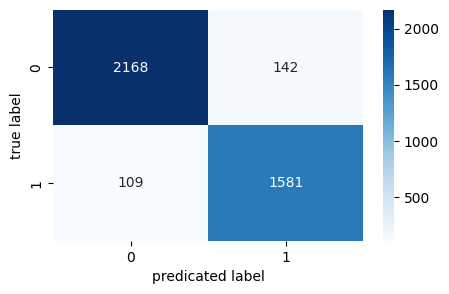

In [133]:

cnt=len(conMatrix)
pd.DataFrame(conMatrix, 
             index=['true_%d' % i for i in range(cnt)],
             columns=['pred_%d' % i for i in range(cnt)] )

import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

In [134]:
from sklearn.metrics import classification_report
print(classification_report(lable_flatten, pred_flatten))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2310
           1       0.92      0.94      0.93      1690

    accuracy                           0.94      4000
   macro avg       0.93      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



### ROC 커브

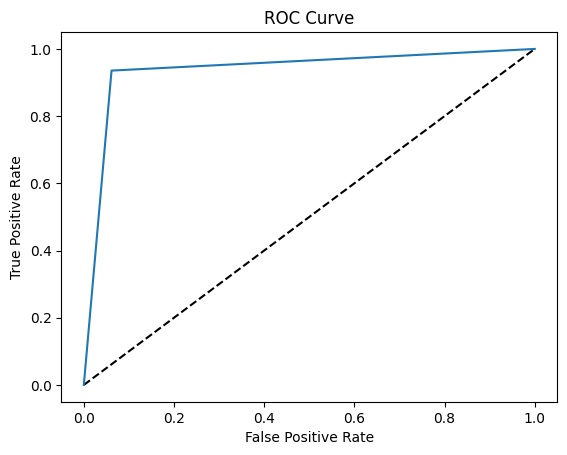

AUC:  0.9370155485540101


In [135]:
# pred_arr_con = np.concatenate(pred_arr)# 
# label_arr_con = np.concatenate(label_arr)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(lable_flatten, pred_flatten)

# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# AUC score
print('AUC: ', roc_auc_score(lable_flatten, pred_flatten))